# Modeling

## Imports

In [1]:
import pandas as pd
import numpy as np

# verify usage of all libraries below
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.regularizers import l2

from tensorflow.keras.activations import elu

## Read Cleaned Data

From the data cleaning notebook, there are two different files:
1. `annual_aqi_clean.csv` is annual summary data from the EPA's AirData system
2. `aqs_by_county_clean.csv` is sensor data that was collected via the EPA's AQS API

The annual summary data will contain more information on the number of days in various areas such as days with AQI measureed, good, moderate, unhealthy, very unhealthy, and hazardous air quality.  There are also columns concerning specific pollutant measurements like pm2.5, pm10, and ozone.

The AQS data is also annual summary data, but on a measured pollutant basis.  So it contains values for measurements of specific pollutants in counties for the year.

In [2]:
# Annual AQI summary data
aqi = pd.read_csv('data/annual_aqi_clean.csv')

# AQS sensor data collected via API
aqs = pd.read_csv('data/aqs_by_county_clean.csv')

In [36]:
aqi.columns

Index(['state', 'county', 'year', 'days_with_aqi', 'good_days', 'mod_days',
       'uh_sens_days', 'uh_days', 'v_uh_days', 'haz_days', 'max_aqi',
       '90_per_aqi', 'median_aqi', 'days_co', 'days_no2', 'days_ozone',
       'days_pm2.5', 'days_pm10', 'births_low', 'avg_weight_low',
       'avg_ges_age_low', 'births_all', 'avg_weight_all', 'avg_ges_age_all',
       'pct_low', 'high_rate'],
      dtype='object')

### Filter Data

The EPA generally uses 75% as a number of observations to ensure relevancy.  So we'll filter the aqi data to only look at records where `days_with_aqi` is greater than 75% of the days in a year.

In [8]:
aqi = aqi[aqi['days_with_aqi'] > (365 * .75)]

In [37]:
X = aqi[['days_with_aqi', 'good_days', 'mod_days',
       'uh_sens_days', 'uh_days', 'v_uh_days', 'haz_days', 'max_aqi',
       '90_per_aqi', 'median_aqi', 'days_co', 'days_no2', 'days_ozone',
       'days_pm2.5', 'days_pm10']]

y = aqi['high_rate']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=.2,
                                                    stratify=y,
                                                    random_state=5)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3242, 15), (811, 15), (3242,), (811,))

In [39]:
train_baseline = pd.DataFrame(y_train).value_counts(normalize=True).iloc[0]
test_baseline = pd.DataFrame(y_test).value_counts(normalize=True).iloc[0]
train_baseline, test_baseline

(0.9019123997532388, 0.9025893958076449)

In [40]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [41]:
custom_elu = lambda x: elu(x, alpha=1e-3)

In [42]:
model = Sequential()
model.add(Dense(16, input_dim=X_train_ss.shape[1], activation=custom_elu,
               kernel_regularizer=l2(0.001)))
# model.add(Dense(300, activation='relu'))
# model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(60, activation=custom_elu))
model.add(Dropout(0.1))
model.add(Dense(120, activation=custom_elu))
model.add(Dropout(0.1))
model.add(Dense(60, activation=custom_elu))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='bce', 
              metrics=['accuracy'])

history = model.fit(X_train_ss, y_train,
                    batch_size=32, epochs=50,
                    validation_data=(X_test_ss, y_test))

Epoch 1/50


2023-01-19 11:09:28.818568: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


102/102 [==============================] - 1s 2ms/step - loss: 0.3597 - accuracy: 0.9001 - val_loss: 0.3272 - val_accuracy: 0.9026
Epoch 2/50
102/102 [==============================] - 0s 1ms/step - loss: 0.3180 - accuracy: 0.9019 - val_loss: 0.3183 - val_accuracy: 0.9026
Epoch 3/50
102/102 [==============================] - 0s 1ms/step - loss: 0.3157 - accuracy: 0.9019 - val_loss: 0.3134 - val_accuracy: 0.9026
Epoch 4/50
102/102 [==============================] - 0s 1ms/step - loss: 0.3111 - accuracy: 0.9019 - val_loss: 0.3091 - val_accuracy: 0.9026
Epoch 5/50
102/102 [==============================] - 0s 1ms/step - loss: 0.3073 - accuracy: 0.9019 - val_loss: 0.3086 - val_accuracy: 0.9026
Epoch 6/50
102/102 [==============================] - 0s 1ms/step - loss: 0.3015 - accuracy: 0.9019 - val_loss: 0.3132 - val_accuracy: 0.9026
Epoch 7/50
102/102 [==============================] - 0s 1ms/step - loss: 0.2982 - accuracy: 0.9022 - val_loss: 0.3067 - val_accuracy: 0.9026
Epoch 8/50
102/10

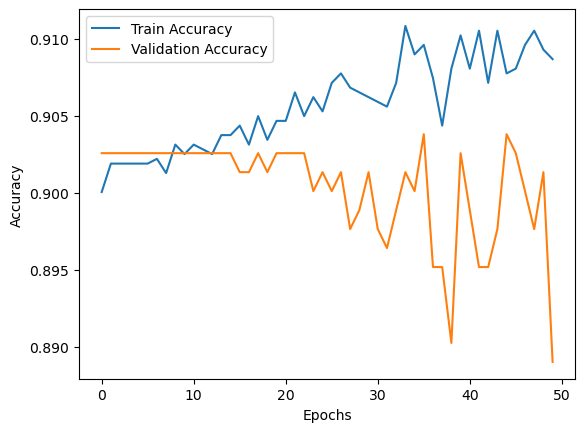

In [43]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend();

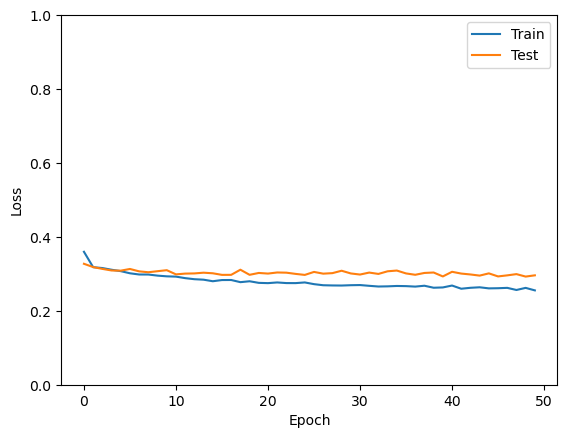

In [44]:
# plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,1])
plt.legend();

### Random Forest Classifier

In [45]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import (cross_val_score, GridSearchCV, 
                                     train_test_split)
from sklearn.pipeline import Pipeline

#### AQI Data

In [54]:
rand_forest = RandomForestClassifier()

In [55]:
rand_forest.fit(X_train, y_train)

RandomForestClassifier()

In [56]:
cross_val_score(rand_forest, X_train, y_train).mean()

0.9056140501055754

In [64]:
# score with defaults
rand_forest.score(X_train, y_train), rand_forest.score(X_test, y_test)

(1.0, 0.8976572133168927)

In [80]:
# configure pipeline
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier())
])

# min_samples_leaf
# criterion

rf_params = {
    'rf__n_estimators': [100, 125, 150],
    'rf__max_depth': [5, 15, 25],
    'rf__min_samples_leaf': [3, 5, 6, 7],
    'rf__bootstrap': [False],
    'rf__warm_start': [True, False],
    'rf__max_features': ['sqrt', 3, 6, 8, 9]
}


# attempt 6 
# rf_params = {
#     'rf__n_estimators': [100, 125, 150],
#     'rf__max_depth': [5, 15, 25],
#     'rf__min_samples_leaf': [3, 5, 6, 7],
#     'rf__bootstrap': [False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 3, 6, 8, 9]
# }

# attempt 5 - first parameters with leaf instead of split
# rf_params = {
#     'rf__n_estimators': [10, 50, 100],
#     'rf__max_depth': [5, 10, 15],
#     'rf__min_samples_leaf': [2, 3, 4, 5],
#     'rf__bootstrap': [True, False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 3, 4, 5, 6]
# }

# attempt 4
# rf_params = {
#     'rf__n_estimators': [100, 125, 150, 200],
#     'rf__max_depth': [10, 15, 20, 25, 100],
#     'rf__min_samples_leaf': [4, 5, 6, 7],
#     'rf__bootstrap': [False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 4, 5, 6, 7]
# }

# attempt 3
# rf_params = {
#     'rf__n_estimators': [100, 125, 150, 200],
#     'rf__max_depth': [10, 15, 20, 25],
#     'rf__min_samples_split': [4, 5, 6, 7],
#     'rf__bootstrap': [False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 4, 5, 6, 7]
# }

# attempt 2
# rf_params = {
#     'rf__n_estimators': [50, 100, 150],
#     'rf__max_depth': [10, 20, 50],
#     'rf__min_samples_split': [5, 10, 25],
#     'rf__bootstrap': [True, False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 5, 10, 25]
# }

# attempt 1
# rf_params = {
#     'rf__n_estimators': [10, 50, 100],
#     'rf__max_depth': [5, 10, 15],
#     'rf__min_samples_split': [2, 3, 4, 5],
#     'rf__bootstrap': [True, False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 3, 4, 5, 6]
# }

In [81]:
gs = GridSearchCV(rf_pipe, rf_params, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
gs.best_params_

# attempt 6 (0.9580505860579889, 0.8988902589395807)
# {'rf__bootstrap': False,
#  'rf__max_depth': 15,
#  'rf__max_features': 'sqrt',
#  'rf__min_samples_leaf': 3,
#  'rf__n_estimators': 125,
#  'rf__warm_start': False}

# attempt 5 (0.9558914250462678, 0.9001233045622689)
# {'rf__bootstrap': False,
#  'rf__max_depth': 15,
#  'rf__max_features': 'sqrt',
#  'rf__min_samples_leaf': 3,
#  'rf__n_estimators': 100,
#  'rf__warm_start': False}

# attempt 4 (0.9487970388648982, 0.8976572133168927)
# {'rf__bootstrap': False,
#  'rf__max_depth': 15,
#  'rf__max_features': 6,
#  'rf__min_samples_leaf': 5,
#  'rf__n_estimators': 100,
#  'rf__warm_start': False}

# attempt 3 (0.9932140653917335, 0.9001233045622689)
# {'rf__bootstrap': False,
#  'rf__max_depth': 15,
#  'rf__max_features': 4,
#  'rf__min_samples_split': 5,
#  'rf__n_estimators': 100,
#  'rf__warm_start': False}

# attempt 2 (1.0, 0.8976572133168927)
# {'rf__bootstrap': False,
#  'rf__max_depth': 20,
#  'rf__max_features': 'sqrt',
#  'rf__min_samples_split': 5,
#  'rf__n_estimators': 150,
#  'rf__warm_start': True}

# attempt 1 (0.9401603948180136, 0.903822441430333)
# {'rf__bootstrap': False,
#  'rf__max_depth': 10,
#  'rf__max_features': 6,
#  'rf__min_samples_split': 5,
#  'rf__n_estimators': 100,
#  'rf__warm_start': False}

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


{'rf__bootstrap': False,
 'rf__max_depth': 15,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 3,
 'rf__n_estimators': 125,
 'rf__warm_start': False}

In [82]:
# score with best params
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9580505860579889, 0.8988902589395807)

In [65]:
aqi['high_rate'].value_counts(normalize=Tr)

0    0.902048
1    0.097952
Name: high_rate, dtype: float64

#### AQS Data

In [99]:
aqs_rf = RandomForestClassifier()

In [100]:
aqs_rf.fit(X_train_aqs, y_train_aqs)

RandomForestClassifier()

In [101]:
cross_val_score(aqs_rf, X_train_aqs, y_train_aqs).mean()

0.8714362395521815

In [104]:
# score with defaults
aqs_rf.score(X_train_aqs, y_train_aqs), aqs_rf.score(X_test_aqs, y_test_aqs)

(1.0, 0.8866995073891626)

In [116]:
# configure pipeline
aqs_rf_pipe = Pipeline([
    ('rf', RandomForestClassifier())
])

# min_samples_leaf
# criterion

aqs_rf_params = {
    'rf__n_estimators': np.arange(25, 300, 50),
    'rf__criterion' : ["gini", "entropy", "log_loss"],
    'rf__max_depth': np.arange(5, 100, 10),
    'rf__min_samples_leaf': np.arange(3, 11),
    'rf__bootstrap': [False, True],
    'rf__warm_start': [True, False],
    'rf__max_features': np.arange(1, 6)
}


# attempt 3
# aqs_rf_params = {
#     'rf__n_estimators': [25, 100, 150, 200],
#     'rf__max_depth': [3, 5, 25, 50],
#     'rf__min_samples_leaf': [3, 5, 6, 7, 20],
#     'rf__bootstrap': [False, True],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', None, 3, 6, 8, 15]
# }

# attempt 2
# aqs_rf_params = {
#     'rf__n_estimators': [100, 125, 150],
#     'rf__max_depth': [5, 15, 25],
#     'rf__min_samples_leaf': [3, 5, 6, 7],
#     'rf__bootstrap': [False, True],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 3, 6, 8, 9]
# }


# attempt 1
# aqs_rf_params = {
#     'rf__n_estimators': [10, 50, 100],
#     'rf__max_depth': [5, 10, 15],
#     'rf__min_samples_split': [2, 3, 4, 5],
#     'rf__bootstrap': [True, False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 3, 4, 5, 6]
# }

In [117]:
aqs_gs = GridSearchCV(aqs_rf_pipe, aqs_rf_params, n_jobs=-1, verbose=1)
aqs_gs.fit(X_train_aqs, y_train_aqs)
aqs_gs.best_params_


# attempt 4 (0.9245982694684796, 0.8768472906403941)
# {'rf__bootstrap': False,
#  'rf__criterion': 'gini',
#  'rf__max_depth': 55,
#  'rf__max_features': 2,
#  'rf__min_samples_leaf': 8,
#  'rf__n_estimators': 25,
#  'rf__warm_start': False}


# attempt 3 (0.9542645241038319, 0.8719211822660099)
# {'rf__bootstrap': True,
#  'rf__max_depth': 50,
#  'rf__max_features': None,
#  'rf__min_samples_leaf': 3,
#  'rf__n_estimators': 25,
#  'rf__warm_start': False}


# attempt 2 (0.8800988875154512, 0.8768472906403941)
# {'rf__bootstrap': False,
#  'rf__max_depth': 5,
#  'rf__max_features': 3,
#  'rf__min_samples_leaf': 3,
#  'rf__n_estimators': 125,
#  'rf__warm_start': False}

# attempt 1 (0.8825710754017305, 0.8768472906403941)
# {'rf__bootstrap': True,
#  'rf__max_depth': 5,
#  'rf__max_features': 'sqrt',
#  'rf__min_samples_split': 4,
#  'rf__n_estimators': 10,
#  'rf__warm_start': True}

Fitting 5 folds for each of 28800 candidates, totalling 144000 fits


{'rf__bootstrap': False,
 'rf__criterion': 'gini',
 'rf__max_depth': 55,
 'rf__max_features': 2,
 'rf__min_samples_leaf': 8,
 'rf__n_estimators': 25,
 'rf__warm_start': False}

In [119]:
# score with best_params
aqs_gs.score(X_train_aqs, y_train_aqs), aqs_gs.score(X_test_aqs, y_test_aqs)

(0.9245982694684796, 0.8768472906403941)

### Logistic Regression Classifer

#### Annual AQI Data

In [83]:
from sklearn.linear_model import LogisticRegression

In [87]:
lr = LogisticRegression(max_iter=10_000)

In [98]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(0    0.901912
 1    0.098088
 Name: high_rate, dtype: float64,
 0    0.902589
 1    0.097411
 Name: high_rate, dtype: float64)

In [88]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [89]:
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9009870450339297, 0.9025893958076449)

#### AQS Data

In [90]:
aqs.columns

Index(['state', 'county', 'year', 'Carbon monoxide', 'Nitrogen dioxide (NO2)',
       'Ozone', 'PM10 Total 0-10um STP', 'PM2.5 - Local Conditions',
       'births_low', 'avg_weight_low', 'avg_ges_age_low', 'births_all',
       'avg_weight_all', 'avg_ges_age_all', 'pct_low', 'high_rate'],
      dtype='object')

In [91]:
X_aqs = aqs[['Carbon monoxide', 'Nitrogen dioxide (NO2)',
       'Ozone', 'PM10 Total 0-10um STP', 'PM2.5 - Local Conditions']]

y_aqs = aqs['high_rate']

In [92]:
X_train_aqs, X_test_aqs, y_train_aqs, y_test_aqs = train_test_split(X_aqs,\
                                                                   y_aqs,
                                                                   random_state=5,
                                                                    test_size=.2,                                                                
                                                                   stratify=y_aqs)

In [93]:
X_train_aqs.shape, X_test_aqs.shape, y_train_aqs.shape, y_test_aqs.shape

((809, 5), (203, 5), (809,), (203,))

In [97]:
y_train_aqs.value_counts(normalize=True), y_test_aqs.value_counts(normalize=True)

(0    0.878863
 1    0.121137
 Name: high_rate, dtype: float64,
 0    0.876847
 1    0.123153
 Name: high_rate, dtype: float64)

In [94]:
lr.fit(X_train_aqs, y_train_aqs)

LogisticRegression(max_iter=10000)

In [96]:
lr.score(X_train_aqs, y_train_aqs), lr.score(X_test_aqs, y_test_aqs)

(0.8788627935723115, 0.8768472906403941)

Regression

In [46]:
# X = aqi[['days_with_aqi', 'good_days', 'mod_days',
#        'uh_sens_days', 'uh_days', 'v_uh_days', 'haz_days', 'max_aqi',
#        '90_per_aqi', 'median_aqi', 'days_co', 'days_no2', 'days_ozone',
#        'days_pm2.5', 'days_pm10']]

# y = aqi['pct_low']

In [47]:
# X_train, X_test, y_train, y_test = train_test_split(X,y,
#                                                     test_size=.2,
#                                                     random_state=5)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [48]:
# ss = StandardScaler()
# X_train_ss = ss.fit_transform(X_train)
# X_test_ss = ss.transform(X_test)

In [49]:
# model = Sequential()
# model.add(Dense(15, input_dim=X_train_ss.shape[1], activation='relu',
#                kernel_regularizer=l2(0.001)))
# # model.add(Dense(300, activation='relu'))
# # model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(60, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(120, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(60, activation='relu'))
# model.add(Dense(1, activation=None))

# model.compile(optimizer='adam', 
#               loss='mse', 
#               metrics=RootMeanSquaredError())

# history = model.fit(X_train_ss, y_train,
#                     batch_size=32, epochs=100,
#                     validation_data=(X_test_ss, y_test),
#                     validation_split=0.25)

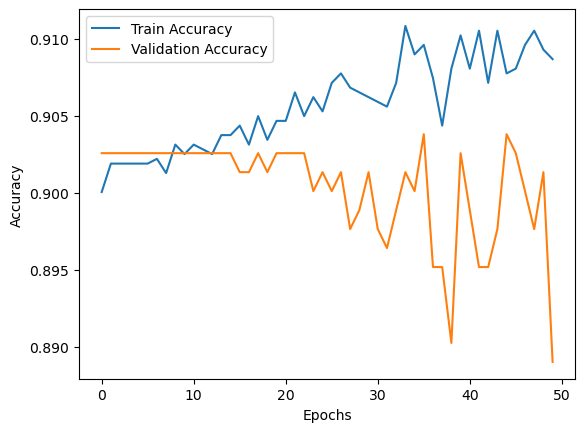

In [50]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [51]:
# # plt.figure(figsize=(8,8))
# plt.plot(history.history['loss'], label='Train')
# plt.plot(history.history['val_loss'], label='Test')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.ylim([0,1])
# plt.legend();

In [52]:
# y_pred = model.predict(X_test_ss)

In [53]:
# plt.scatter(y_test, y_pred, alpha=.6)